In [1]:
%load_ext autoreload
%autoreload 2
from dds.configs.config import set_task, get_config
from dds.train_dds import train_dds
import numpy as onp
import jax

import distrax
import jax.numpy as jnp
import haiku as hk
from jaxline import utils

import functools
import timeit
from typing import Any, List, Tuple, Optional
from absl import app, flags

from absl import logging
import haiku as hk
import distrax
import jax
import jax.numpy as jnp

from ml_collections import config_dict as configdict
from ml_collections import config_flags

import numpy as onp
import optax

from jaxline import utils

from dds.configs.config import set_task
from dds.data_paths import results_path
from dds.utils import flatten_nested_dict
import wandb
print(jax.devices())

2023-08-15 14:11:08.806096: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-15 14:11:08.806191: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-08-15 14:11:08.806200: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]


In [2]:
from dds.objectives import controlled_ais_relative_kl_objective
from dds.objectives import controlled_ais_importance_weighted_partition_estimate_dds


config = get_config()

# Time and step settings (Need to be done before calling set_task)
config.model.tfinal = 6.4
# config.model.tfinal = 10
config.model.dt = 0.05

config.model.reference_process_key = "cais"

config.trainer.objective = controlled_ais_relative_kl_objective
config.trainer.lnz_is_estimator = controlled_ais_importance_weighted_partition_estimate_dds

if config.model.reference_process_key == "oudstl":
    config.model.step_scheme_key = "cos_sq"

config = set_task(config, "lr_sonar")

if config.model.reference_process_key == "oudstl":
    config.model.step_scheme_key = "cos_sq"
    
    # Opt setting for funnel
    config.model.sigma = 1.
    config.model.alpha = 0.6875
    config.model.m = 1.0
        
    # Path opt settings    
    config.model.exp_dds = False

if config.model.reference_process_key == "cais":
    config.model.step_scheme_key = "linear"
    
    # Opt setting for funnel
    config.model.alpha = 0.6875
    config.model.m = 1.0
        
    # Path opt settings    
    config.model.exp_dds = False
    
    if config.task == "funnel":
        config.model.sigma = 1.25
        config.model.sigma_base = 1.75
        
    if config.task == "lr_sonar":
        config.model.sigma = 0.5
        config.model.sigma_base = 0.6
    


config.model.stl = False
config.model.detach_stl_drift = False

config.trainer.notebook = True
config.trainer.epochs = 200  #  11000
# Opt settings we use
# funnel_config.trainer.learning_rate = 0.0001
config.trainer.learning_rate = 5 * 10**(-3)
config.trainer.lr_sch_base_dec = 0.95 # For funnel
config.model.reference_process_key = "cais"
# config.trainer.learning_rate = 0
config.trainer.epochs = 6000
config.trainer.learning_rate = 1 * 10**(-5)

In [3]:
def update_detached_params(trainable_params, non_trainable_params,
                           attached_network_name="simple_drift_net",
                           detached_network_name="stl_detach"):
  """Auxiliary function updating detached params for STL.

  Args:
      trainable_params:
      non_trainable_params:
      attached_network_name:
      detached_network_name:
  Returns:
    Returns non trainable params
  """

  if len(trainable_params) != len(non_trainable_params):
    return non_trainable_params

  for key in trainable_params.keys():
    if attached_network_name in key:
      key_det = key.replace(attached_network_name, detached_network_name)
    else:
      key_det = key.replace("diffusion_network",
                            detached_network_name + "_diff")
    non_trainable_params[key_det] = trainable_params[key]  # pytype: disable=unsupported-operands

  return non_trainable_params

data_dim = config.model.input_dim
device_no = jax.device_count()

results_path = '~/denoising_diffusion_samplers/results'
alpha = config.model.alpha
sigma = config.model.sigma
m = config.model.m

if config.model.reference_process_key == "oudstl":
    config.model.sigma_base = config.model.sigma

# post setup model vars
config.model.source_obj = distrax.MultivariateNormalDiag(
    jnp.zeros(config.model.input_dim),
    config.model.sigma_base * jnp.ones(config.model.input_dim))
config.model.source = config.model.source_obj.log_prob

batch_size_ = int(config.model.batch_size / device_no)
batch_size_elbo = int(config.model.elbo_batch_size / device_no)

step_scheme = config.model.step_scheme_dict[config.model.step_scheme_key]

dt = config.model.dt

if config.model.reference_process_key == "oududp":
    key_conversion = {
        "pis": "pisudp",
        "vanilla": "vanilla_udp",
        "tmpis": "tmpis_udp"
    }
    # "pisudp"
    config.model.network_key = key_conversion[config.model.network_key]

net_key = config.model.network_key
network = config.model.network_dict[net_key]

tpu = config.model.tpu

detach_dif_path, detach_dritf_path = (
    config.model.detach_path, config.model.detach_path)

target = config.model.target

tfinal = config.model.tfinal
lnpi = config.trainer.lnpi

ref_proc_key = config.model.reference_process_key
ref_proc = config.model.reference_process_dict[ref_proc_key]

trim = (2 if "stl" in str(ref_proc).lower() or "udp" in str(ref_proc).lower()
        else 1)

stl = config.model.stl

brown = "brown" in str(ref_proc).lower()

seed = config.trainer.random_seed  if "random_seed" in config.trainer else 42

# task directory (currently not in use)
task = config.task
method = config.model.reference_process_key
task_path = results_path + f"/{task}" + f"/{ref_proc_key}" + f"/{net_key}"
task_path += f"/{method}"


# checkpoiting variables for wandb
nsteps = config.model.ts.shape[0]
keep_every_nth = int(config.trainer.epochs / 125)
file_name = (f"/alpha_{alpha}_sigma_{sigma}_epochs_{config.trainer.epochs}" +
            f"_task_{task}_seed_{seed}_steps_{nsteps}_stl_{stl}_{method}" +
            f"_scheme_{config.model.step_scheme_key}_ddpm_test11_chk")
_ = task_path + file_name

detach_stl_drift = (
    config.model.detach_stl_drift if
    "detach_stl_drift" in config.model else False
)

drift_network = lambda: network(config.model, data_dim, "simple_drift_net")

############## wandb logging  place holder ################
data_id = "denoising_diffusion_samplers"  # Project name

In [4]:
from turtle import forward


def _forward_fn(batch_size: int,
                training: bool = True,
                ode=False, exact=False, dt_=dt) -> jnp.ndarray:

    model_def = ref_proc(
        sigma, 
        data_dim, 
        drift_network, 
        tfinal=tfinal, 
        dt=dt_,
        step_scheme=step_scheme, 
        alpha=alpha, 
        target=target, 
        tpu=tpu,
        detach_stl_drift=detach_stl_drift, 
        diff_net=None,
        detach_dritf_path=detach_dritf_path, 
        detach_dif_path=detach_dif_path,
        m=m, 
        log=config.model.log, 
        exp_bool=config.model.exp_dds, 
        exact=exact
    )

    return model_def(batch_size, training, ode=ode)

forward_fn = hk.transform_with_state(_forward_fn)  

print(forward_fn)


TransformedWithState(init=<function transform_with_state.<locals>.init_fn at 0x7efd44502440>, apply=<function transform_with_state.<locals>.apply_fn at 0x7efd445025f0>)


In [5]:
# opt and loss setup
seq = hk.PRNGSequence(seed)
rng_key = next(seq)
# subkeys = jax.random.split(rng_key, device_no)
subkeys = utils.bcast_local_devices(rng_key)

p_init = jax.pmap(
    functools.partial(forward_fn.init, batch_size=batch_size_,
                        training=True), axis_name="num_devices")

params, model_state = p_init(subkeys)

trainable_params, non_trainable_params = hk.data_structures.partition(
    lambda module, name, value: "stl_detach" not in module, params)

clipper = optax.clip(1.0)
base_dec = config.trainer.lr_sch_base_dec
scale_by_adam = optax.scale_by_adam()
# if base_dec == 0:
#   scale_by_lr = optax.scale(-config.trainer.learning_rate)
#   opt = optax.chain(clipper, scale_by_adam, scale_by_lr)
# else:
transition_steps = 50
exp_lr = optax.exponential_decay(config.trainer.learning_rate,
                                transition_steps, base_dec)
scale_lr = optax.scale_by_schedule(exp_lr)
opt = optax.chain(clipper, scale_by_adam, scale_lr, optax.scale(-1))

# opt = optax.adam(learning_rate=config.trainer.learning_rate)
opt_state = jax.pmap(opt.init)(trainable_params)

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(3, 4, 5, 6))
def forward_fn_jit(
    params,
    model_state: hk.State,
    subkeys: jnp.ndarray,
    batch_size: jnp.ndarray, ode=False, exact=False,  dt_=dt):

    samps, _ = forward_fn.apply(
        params,
        model_state,
        subkeys,
        int(batch_size / device_no),
        False,
        ode=ode, exact=exact, dt_=dt_)
    samps = jax.device_get(samps)

    augmented_trajectory, ts = samps
    return (augmented_trajectory, ts), _

def forward_fn_wrap(
    params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray, ode=False, exact=False, dt_=dt):
    subkeys = jax.random.split(rng_key, device_no)
    (augmented_trajectory, ts), _ = forward_fn_jit(params, model_state,
                                                subkeys, batch_size, ode, exact,
                                                dt_)

    dv, ns, t, _ = augmented_trajectory.shape
    augmented_trajectory = augmented_trajectory.reshape(dv*ns, t, -1)
    return (augmented_trajectory, utils.get_first(ts)), _

In [6]:
def full_objective(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: int,
    is_training: bool = True,
    ode: bool = False,
    stl: bool = False,
    exact: bool = False,
  ):

  params = hk.data_structures.merge(trainable_params, non_trainable_params)
  (augmented_trajectory, _), model_state = forward_fn.apply(
      params, model_state, rng_key, batch_size, True, ode, exact
  )

  # import pdb; pdb.set_trace()
  gpartial = functools.partial(
      config.model.terminal_cost,
      lnpi=lnpi, sigma=sigma, tfinal=tfinal, brown=brown)
  
  if is_training:
    loss = config.trainer.objective(
        augmented_trajectory, gpartial, source=config.model.source, target=config.model.target, stl=stl, trim=trim, dim=data_dim)
  elif not ode:
    loss = config.trainer.lnz_is_estimator(
        augmented_trajectory, gpartial, source=config.model.source, target=config.model.target, dim=data_dim)
  else:
    loss = config.trainer.lnz_pf_estimator(
        augmented_trajectory, config.model.source, config.model.target)
  return loss, model_state

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(5,))
def update(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    opt_state: Any,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray):
  grads, new_model_state = jax.grad(
      full_objective, has_aux=True)(
          trainable_params,
          non_trainable_params,
          model_state,
          rng_key,
          batch_size,
          is_training=True,
          stl=stl)
  grads = jax.lax.pmean(grads, axis_name="num_devices")

  updates, opt_state = opt.update(grads, opt_state)
  new_params = optax.apply_updates(trainable_params, updates)
  return new_params, opt_state, new_model_state

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(4, 5, 6, 7))
def jited_val_loss(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray,
    is_training: bool = True,
    ode: bool = False,
    exact: bool = False,):

  loss, new_model_state = full_objective(
      trainable_params,
      non_trainable_params,
      model_state,
      rng_key,
      batch_size,
      is_training=is_training, ode=ode,
      stl=False, exact=exact,)

  loss = jax.lax.pmean(loss, axis_name="num_devices")
  return loss, new_model_state

def eval_report(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: int,
    epoch: int,
    loss_list: List[float],
    is_training: bool = True,
    print_flag: bool = False,
    ode: bool = False,
    exact: bool = False,
    wandb_run=None,
    wandb_key: Optional[str] = None,
) -> None:

  loss, model_state = jited_val_loss(
      trainable_params, non_trainable_params,
      model_state, rng_key, batch_size, is_training, ode, exact)
  loss = jax.device_get(loss)
  loss = onp.asarray(utils.get_first(loss).item()).item()

  log_string = "epoch: %s %s  loss: %s", epoch, "TRAIN", loss
  logging.info(log_string)
  if config.trainer.notebook and print_flag: print(log_string)

  loss_list.append(loss)
  if wandb_run:
    wandb_run.log({f"{wandb_key}/epoch": epoch, f"{wandb_key}/loss": loss})
  # writer.flush()

loss_list = []
loss_list_is = []
loss_list_pf = []

start = 0
times = []

run = None

for epoch in range(start, config.trainer.epochs):
  rng_key = next(seq)
  subkeys = jax.random.split(rng_key, device_no)
  
  if epoch == 0:
      eval_report(trainable_params, non_trainable_params,
                    model_state, subkeys, batch_size_elbo, epoch - 1,
                    loss_list, print_flag=True, wandb_run=run, wandb_key="elbo_results")
  if config.trainer.epochs == 1:
    break

  trainable_params, opt_state, model_state = update(trainable_params,
                                                    non_trainable_params,
                                                    model_state, opt_state,
                                                    subkeys, batch_size_)
  if config.trainer.timer:
    def func():
      return jax.block_until_ready(
          update(trainable_params, non_trainable_params, model_state,
                opt_state, subkeys, batch_size_))

    delta_time = timeit.timeit(func, number=1)
    times.append(delta_time)

  update_detached_params(trainable_params, non_trainable_params,
                        "simple_drift_net", "stl_detach")

  if epoch % config.trainer.log_every_n_epochs == 0:

    eval_report(trainable_params, non_trainable_params,
                model_state, subkeys, batch_size_elbo, epoch,
                loss_list, print_flag=True, wandb_run=run, wandb_key="elbo_results")

    eval_report(trainable_params, non_trainable_params,
                model_state, subkeys, batch_size_elbo, epoch,
                loss_list_is, is_training=False, wandb_run=run, wandb_key="is_results")

    eval_report(trainable_params, non_trainable_params,
                model_state, subkeys, batch_size_elbo, epoch,
                loss_list_pf, is_training=False, ode=True, wandb_run=run, wandb_key="pf_results")

    lr = onp.asarray(exp_lr(epoch).item()).item()
    if run:
        run.log({"lr/epoch": epoch, "lr/lr": lr})

loss_list_is_eval, loss_list_eval, loss_list_pf_eval = [], [], []
for i in range(config.eval.seeds):
  rng_key = next(seq)
  subkeys = jax.random.split(rng_key, device_no)
  eval_report(
      trainable_params,
      non_trainable_params,
      model_state,
      subkeys,
      batch_size_elbo,
      i,
      loss_list_eval,
      print_flag=True,
      wandb_run=run,
      wandb_key="elbo_results_eval",)

  eval_report(
      trainable_params,
      non_trainable_params,
      model_state,
      subkeys,
      batch_size_elbo,
      i,
      loss_list_is_eval,
      is_training=False,
      wandb_run=run,
      wandb_key="is_results_eval",)

  eval_report(
      trainable_params,
      non_trainable_params,
      model_state,
      subkeys,
      batch_size_elbo,
      i,
      loss_list_pf_eval,
      is_training=False, ode=True, exact=False,
      wandb_run=run,
      wandb_key="pf_results_eval",)

params = hk.data_structures.merge(trainable_params, non_trainable_params)
if config.trainer.timer:
  print(times[1:])

samps = 2500
if method == "lgcp" and tfinal >= 12:
  samps = 100

(augmented_trajectory, _), _ = forward_fn_wrap(params, model_state, rng_key,
                                              samps)

(augmented_trajectory_det, _), _ = forward_fn_wrap(params, model_state,
                                                  rng_key, samps, True, False)
  
(augmented_trajectory_det_ext, _), _ = forward_fn_wrap(params, model_state,
                                                      rng_key, samps, True, True)


results_dict = {
    "elbo": loss_list,
    "is": loss_list_is,
    "pf": loss_list_pf,
    "elbo_eval": loss_list_eval,
    "is_eval": loss_list_is_eval,
    "pf_eval": loss_list_pf_eval,
    "aug": augmented_trajectory,
    "aug_ode": augmented_trajectory_det,
    "aug_ode_ext": augmented_trajectory_det_ext
}

('epoch: %s %s  loss: %s', -1, 'TRAIN', 133.85366821289062)
('epoch: %s %s  loss: %s', 0, 'TRAIN', 133.78335571289062)
('epoch: %s %s  loss: %s', 1, 'TRAIN', 134.95289611816406)
('epoch: %s %s  loss: %s', 2, 'TRAIN', 134.45648193359375)
('epoch: %s %s  loss: %s', 3, 'TRAIN', 133.69590759277344)
('epoch: %s %s  loss: %s', 4, 'TRAIN', 133.9390411376953)
('epoch: %s %s  loss: %s', 5, 'TRAIN', 134.09573364257812)
('epoch: %s %s  loss: %s', 6, 'TRAIN', 133.72769165039062)
('epoch: %s %s  loss: %s', 7, 'TRAIN', 133.75584411621094)
('epoch: %s %s  loss: %s', 8, 'TRAIN', 133.2779998779297)
('epoch: %s %s  loss: %s', 9, 'TRAIN', 133.969970703125)
('epoch: %s %s  loss: %s', 10, 'TRAIN', 133.1086883544922)
('epoch: %s %s  loss: %s', 11, 'TRAIN', 133.4307098388672)
('epoch: %s %s  loss: %s', 12, 'TRAIN', 132.57447814941406)
('epoch: %s %s  loss: %s', 13, 'TRAIN', 133.75819396972656)
('epoch: %s %s  loss: %s', 14, 'TRAIN', 133.7296905517578)
('epoch: %s %s  loss: %s', 15, 'TRAIN', 133.5653228759765

('epoch: %s %s  loss: %s', 138, 'TRAIN', 126.71045684814453)
('epoch: %s %s  loss: %s', 139, 'TRAIN', 127.2303695678711)
('epoch: %s %s  loss: %s', 140, 'TRAIN', 127.12739562988281)
('epoch: %s %s  loss: %s', 141, 'TRAIN', 127.56562805175781)
('epoch: %s %s  loss: %s', 142, 'TRAIN', 127.02547454833984)
('epoch: %s %s  loss: %s', 143, 'TRAIN', 126.8988037109375)
('epoch: %s %s  loss: %s', 144, 'TRAIN', 127.22148895263672)
('epoch: %s %s  loss: %s', 145, 'TRAIN', 127.11307525634766)
('epoch: %s %s  loss: %s', 146, 'TRAIN', 126.70490264892578)
('epoch: %s %s  loss: %s', 147, 'TRAIN', 127.3180923461914)
('epoch: %s %s  loss: %s', 148, 'TRAIN', 126.7327880859375)
('epoch: %s %s  loss: %s', 149, 'TRAIN', 127.11862182617188)
('epoch: %s %s  loss: %s', 150, 'TRAIN', 126.96745300292969)
('epoch: %s %s  loss: %s', 151, 'TRAIN', 127.59825897216797)
('epoch: %s %s  loss: %s', 152, 'TRAIN', 126.42552185058594)
('epoch: %s %s  loss: %s', 153, 'TRAIN', 127.20185089111328)
('epoch: %s %s  loss: %s', 1

('epoch: %s %s  loss: %s', 273, 'TRAIN', 125.3723373413086)
('epoch: %s %s  loss: %s', 274, 'TRAIN', 124.4651870727539)
('epoch: %s %s  loss: %s', 275, 'TRAIN', 124.58075714111328)
('epoch: %s %s  loss: %s', 276, 'TRAIN', 124.77853393554688)
('epoch: %s %s  loss: %s', 277, 'TRAIN', 124.49573516845703)
('epoch: %s %s  loss: %s', 278, 'TRAIN', 125.10613250732422)
('epoch: %s %s  loss: %s', 279, 'TRAIN', 124.63286590576172)
('epoch: %s %s  loss: %s', 280, 'TRAIN', 124.89634704589844)
('epoch: %s %s  loss: %s', 281, 'TRAIN', 125.0124740600586)
('epoch: %s %s  loss: %s', 282, 'TRAIN', 124.07678985595703)
('epoch: %s %s  loss: %s', 283, 'TRAIN', 123.67739868164062)
('epoch: %s %s  loss: %s', 284, 'TRAIN', 124.61683654785156)
('epoch: %s %s  loss: %s', 285, 'TRAIN', 124.31804656982422)
('epoch: %s %s  loss: %s', 286, 'TRAIN', 123.9358139038086)
('epoch: %s %s  loss: %s', 287, 'TRAIN', 123.83606719970703)
('epoch: %s %s  loss: %s', 288, 'TRAIN', 124.41385650634766)
('epoch: %s %s  loss: %s', 2

('epoch: %s %s  loss: %s', 409, 'TRAIN', 122.38888549804688)
('epoch: %s %s  loss: %s', 410, 'TRAIN', 123.0959701538086)
('epoch: %s %s  loss: %s', 411, 'TRAIN', 122.50128173828125)
('epoch: %s %s  loss: %s', 412, 'TRAIN', 123.5089340209961)
('epoch: %s %s  loss: %s', 413, 'TRAIN', 122.76810455322266)
('epoch: %s %s  loss: %s', 414, 'TRAIN', 123.10398864746094)
('epoch: %s %s  loss: %s', 415, 'TRAIN', 122.94596862792969)
('epoch: %s %s  loss: %s', 416, 'TRAIN', 122.5909652709961)
('epoch: %s %s  loss: %s', 417, 'TRAIN', 122.38591766357422)
('epoch: %s %s  loss: %s', 418, 'TRAIN', 123.69672393798828)
('epoch: %s %s  loss: %s', 419, 'TRAIN', 122.97206115722656)
('epoch: %s %s  loss: %s', 420, 'TRAIN', 123.5452651977539)
('epoch: %s %s  loss: %s', 421, 'TRAIN', 122.5628662109375)
('epoch: %s %s  loss: %s', 422, 'TRAIN', 123.4059829711914)
('epoch: %s %s  loss: %s', 423, 'TRAIN', 122.67820739746094)
('epoch: %s %s  loss: %s', 424, 'TRAIN', 122.50548553466797)
('epoch: %s %s  loss: %s', 425

('epoch: %s %s  loss: %s', 545, 'TRAIN', 121.45431518554688)
('epoch: %s %s  loss: %s', 546, 'TRAIN', 121.7132339477539)
('epoch: %s %s  loss: %s', 547, 'TRAIN', 121.83187866210938)
('epoch: %s %s  loss: %s', 548, 'TRAIN', 121.69104766845703)
('epoch: %s %s  loss: %s', 549, 'TRAIN', 121.34654998779297)
('epoch: %s %s  loss: %s', 550, 'TRAIN', 121.75182342529297)
('epoch: %s %s  loss: %s', 551, 'TRAIN', 121.11695861816406)
('epoch: %s %s  loss: %s', 552, 'TRAIN', 121.45133209228516)
('epoch: %s %s  loss: %s', 553, 'TRAIN', 121.82901000976562)
('epoch: %s %s  loss: %s', 554, 'TRAIN', 122.12965393066406)
('epoch: %s %s  loss: %s', 555, 'TRAIN', 121.39883422851562)
('epoch: %s %s  loss: %s', 556, 'TRAIN', 121.4099349975586)
('epoch: %s %s  loss: %s', 557, 'TRAIN', 121.36807250976562)
('epoch: %s %s  loss: %s', 558, 'TRAIN', 120.75479125976562)
('epoch: %s %s  loss: %s', 559, 'TRAIN', 121.47989654541016)
('epoch: %s %s  loss: %s', 560, 'TRAIN', 121.50859832763672)
('epoch: %s %s  loss: %s',

('epoch: %s %s  loss: %s', 681, 'TRAIN', 120.67208862304688)
('epoch: %s %s  loss: %s', 682, 'TRAIN', 120.84503936767578)
('epoch: %s %s  loss: %s', 683, 'TRAIN', 120.35164642333984)
('epoch: %s %s  loss: %s', 684, 'TRAIN', 120.33841705322266)
('epoch: %s %s  loss: %s', 685, 'TRAIN', 120.69690704345703)
('epoch: %s %s  loss: %s', 686, 'TRAIN', 120.4253158569336)
('epoch: %s %s  loss: %s', 687, 'TRAIN', 120.52444458007812)
('epoch: %s %s  loss: %s', 688, 'TRAIN', 120.43919372558594)
('epoch: %s %s  loss: %s', 689, 'TRAIN', 120.51057434082031)
('epoch: %s %s  loss: %s', 690, 'TRAIN', 120.66136932373047)
('epoch: %s %s  loss: %s', 691, 'TRAIN', 119.80130767822266)
('epoch: %s %s  loss: %s', 692, 'TRAIN', 120.37538146972656)
('epoch: %s %s  loss: %s', 693, 'TRAIN', 120.6642074584961)
('epoch: %s %s  loss: %s', 694, 'TRAIN', 120.27220153808594)
('epoch: %s %s  loss: %s', 695, 'TRAIN', 120.73880767822266)
('epoch: %s %s  loss: %s', 696, 'TRAIN', 120.46185302734375)
('epoch: %s %s  loss: %s',

('epoch: %s %s  loss: %s', 816, 'TRAIN', 119.47781372070312)
('epoch: %s %s  loss: %s', 817, 'TRAIN', 119.41915893554688)
('epoch: %s %s  loss: %s', 818, 'TRAIN', 119.43375396728516)
('epoch: %s %s  loss: %s', 819, 'TRAIN', 119.35596466064453)
('epoch: %s %s  loss: %s', 820, 'TRAIN', 119.24380493164062)
('epoch: %s %s  loss: %s', 821, 'TRAIN', 119.90716552734375)
('epoch: %s %s  loss: %s', 822, 'TRAIN', 119.57820892333984)
('epoch: %s %s  loss: %s', 823, 'TRAIN', 120.11539459228516)
('epoch: %s %s  loss: %s', 824, 'TRAIN', 119.55543518066406)
('epoch: %s %s  loss: %s', 825, 'TRAIN', 120.12805938720703)
('epoch: %s %s  loss: %s', 826, 'TRAIN', 119.31854248046875)
('epoch: %s %s  loss: %s', 827, 'TRAIN', 119.57425689697266)
('epoch: %s %s  loss: %s', 828, 'TRAIN', 119.72025299072266)
('epoch: %s %s  loss: %s', 829, 'TRAIN', 119.72989654541016)
('epoch: %s %s  loss: %s', 830, 'TRAIN', 119.49488830566406)
('epoch: %s %s  loss: %s', 831, 'TRAIN', 119.63702392578125)
('epoch: %s %s  loss: %s

('epoch: %s %s  loss: %s', 951, 'TRAIN', 119.05265808105469)
('epoch: %s %s  loss: %s', 952, 'TRAIN', 118.83915710449219)
('epoch: %s %s  loss: %s', 953, 'TRAIN', 119.14242553710938)
('epoch: %s %s  loss: %s', 954, 'TRAIN', 118.74505615234375)
('epoch: %s %s  loss: %s', 955, 'TRAIN', 119.82694244384766)
('epoch: %s %s  loss: %s', 956, 'TRAIN', 119.5565414428711)
('epoch: %s %s  loss: %s', 957, 'TRAIN', 119.50302124023438)
('epoch: %s %s  loss: %s', 958, 'TRAIN', 118.90412902832031)
('epoch: %s %s  loss: %s', 959, 'TRAIN', 119.11799621582031)
('epoch: %s %s  loss: %s', 960, 'TRAIN', 119.01795959472656)
('epoch: %s %s  loss: %s', 961, 'TRAIN', 119.35909271240234)
('epoch: %s %s  loss: %s', 962, 'TRAIN', 119.21607208251953)
('epoch: %s %s  loss: %s', 963, 'TRAIN', 118.66450500488281)
('epoch: %s %s  loss: %s', 964, 'TRAIN', 119.27603149414062)
('epoch: %s %s  loss: %s', 965, 'TRAIN', 118.75567626953125)
('epoch: %s %s  loss: %s', 966, 'TRAIN', 118.84153747558594)
('epoch: %s %s  loss: %s'

('epoch: %s %s  loss: %s', 1086, 'TRAIN', 119.11833953857422)
('epoch: %s %s  loss: %s', 1087, 'TRAIN', 118.86495208740234)
('epoch: %s %s  loss: %s', 1088, 'TRAIN', 118.33597564697266)
('epoch: %s %s  loss: %s', 1089, 'TRAIN', 118.5346908569336)
('epoch: %s %s  loss: %s', 1090, 'TRAIN', 118.26731872558594)
('epoch: %s %s  loss: %s', 1091, 'TRAIN', 118.74139404296875)
('epoch: %s %s  loss: %s', 1092, 'TRAIN', 118.69013214111328)
('epoch: %s %s  loss: %s', 1093, 'TRAIN', 118.97845458984375)
('epoch: %s %s  loss: %s', 1094, 'TRAIN', 118.84708404541016)
('epoch: %s %s  loss: %s', 1095, 'TRAIN', 118.36682891845703)
('epoch: %s %s  loss: %s', 1096, 'TRAIN', 118.97372436523438)
('epoch: %s %s  loss: %s', 1097, 'TRAIN', 119.18836212158203)
('epoch: %s %s  loss: %s', 1098, 'TRAIN', 118.59290313720703)
('epoch: %s %s  loss: %s', 1099, 'TRAIN', 118.69158172607422)
('epoch: %s %s  loss: %s', 1100, 'TRAIN', 118.64612579345703)
('epoch: %s %s  loss: %s', 1101, 'TRAIN', 118.88751220703125)
('epoch: 

('epoch: %s %s  loss: %s', 1220, 'TRAIN', 118.58776092529297)
('epoch: %s %s  loss: %s', 1221, 'TRAIN', 118.41661834716797)
('epoch: %s %s  loss: %s', 1222, 'TRAIN', 118.3038330078125)
('epoch: %s %s  loss: %s', 1223, 'TRAIN', 118.76846313476562)
('epoch: %s %s  loss: %s', 1224, 'TRAIN', 118.50135803222656)
('epoch: %s %s  loss: %s', 1225, 'TRAIN', 118.52867126464844)
('epoch: %s %s  loss: %s', 1226, 'TRAIN', 118.55831146240234)
('epoch: %s %s  loss: %s', 1227, 'TRAIN', 118.98820495605469)
('epoch: %s %s  loss: %s', 1228, 'TRAIN', 118.80730438232422)
('epoch: %s %s  loss: %s', 1229, 'TRAIN', 117.85539245605469)
('epoch: %s %s  loss: %s', 1230, 'TRAIN', 118.8007583618164)
('epoch: %s %s  loss: %s', 1231, 'TRAIN', 118.5984115600586)
('epoch: %s %s  loss: %s', 1232, 'TRAIN', 118.50430297851562)
('epoch: %s %s  loss: %s', 1233, 'TRAIN', 118.78215026855469)
('epoch: %s %s  loss: %s', 1234, 'TRAIN', 118.55938720703125)
('epoch: %s %s  loss: %s', 1235, 'TRAIN', 118.5743408203125)
('epoch: %s 

('epoch: %s %s  loss: %s', 1354, 'TRAIN', 118.4303970336914)
('epoch: %s %s  loss: %s', 1355, 'TRAIN', 118.41258239746094)
('epoch: %s %s  loss: %s', 1356, 'TRAIN', 117.8816146850586)
('epoch: %s %s  loss: %s', 1357, 'TRAIN', 118.4460678100586)
('epoch: %s %s  loss: %s', 1358, 'TRAIN', 118.33344268798828)
('epoch: %s %s  loss: %s', 1359, 'TRAIN', 118.70401000976562)
('epoch: %s %s  loss: %s', 1360, 'TRAIN', 117.98823547363281)
('epoch: %s %s  loss: %s', 1361, 'TRAIN', 117.8753662109375)
('epoch: %s %s  loss: %s', 1362, 'TRAIN', 118.076904296875)
('epoch: %s %s  loss: %s', 1363, 'TRAIN', 117.48567962646484)
('epoch: %s %s  loss: %s', 1364, 'TRAIN', 118.14163970947266)
('epoch: %s %s  loss: %s', 1365, 'TRAIN', 117.83531188964844)
('epoch: %s %s  loss: %s', 1366, 'TRAIN', 118.06414031982422)
('epoch: %s %s  loss: %s', 1367, 'TRAIN', 118.0292739868164)
('epoch: %s %s  loss: %s', 1368, 'TRAIN', 118.2717514038086)
('epoch: %s %s  loss: %s', 1369, 'TRAIN', 118.44341278076172)
('epoch: %s %s  

('epoch: %s %s  loss: %s', 1487, 'TRAIN', 118.41521453857422)
('epoch: %s %s  loss: %s', 1488, 'TRAIN', 118.25203704833984)
('epoch: %s %s  loss: %s', 1489, 'TRAIN', 118.14181518554688)
('epoch: %s %s  loss: %s', 1490, 'TRAIN', 118.26837158203125)
('epoch: %s %s  loss: %s', 1491, 'TRAIN', 118.35643768310547)
('epoch: %s %s  loss: %s', 1492, 'TRAIN', 118.1243896484375)
('epoch: %s %s  loss: %s', 1493, 'TRAIN', 118.17295837402344)
('epoch: %s %s  loss: %s', 1494, 'TRAIN', 118.39952087402344)
('epoch: %s %s  loss: %s', 1495, 'TRAIN', 118.20330810546875)
('epoch: %s %s  loss: %s', 1496, 'TRAIN', 117.66545867919922)
('epoch: %s %s  loss: %s', 1497, 'TRAIN', 118.02596282958984)
('epoch: %s %s  loss: %s', 1498, 'TRAIN', 118.07357025146484)
('epoch: %s %s  loss: %s', 1499, 'TRAIN', 118.01213836669922)
('epoch: %s %s  loss: %s', 1500, 'TRAIN', 117.8476333618164)
('epoch: %s %s  loss: %s', 1501, 'TRAIN', 118.35196685791016)
('epoch: %s %s  loss: %s', 1502, 'TRAIN', 118.07474517822266)
('epoch: %

('epoch: %s %s  loss: %s', 1621, 'TRAIN', 117.76156616210938)
('epoch: %s %s  loss: %s', 1622, 'TRAIN', 118.0114517211914)
('epoch: %s %s  loss: %s', 1623, 'TRAIN', 117.9211654663086)
('epoch: %s %s  loss: %s', 1624, 'TRAIN', 117.60391235351562)
('epoch: %s %s  loss: %s', 1625, 'TRAIN', 118.3742446899414)
('epoch: %s %s  loss: %s', 1626, 'TRAIN', 117.51820373535156)
('epoch: %s %s  loss: %s', 1627, 'TRAIN', 117.9725570678711)
('epoch: %s %s  loss: %s', 1628, 'TRAIN', 118.45562744140625)
('epoch: %s %s  loss: %s', 1629, 'TRAIN', 118.32257843017578)
('epoch: %s %s  loss: %s', 1630, 'TRAIN', 117.64384460449219)
('epoch: %s %s  loss: %s', 1631, 'TRAIN', 117.95945739746094)
('epoch: %s %s  loss: %s', 1632, 'TRAIN', 118.1218032836914)
('epoch: %s %s  loss: %s', 1633, 'TRAIN', 117.9504165649414)
('epoch: %s %s  loss: %s', 1634, 'TRAIN', 118.30250549316406)
('epoch: %s %s  loss: %s', 1635, 'TRAIN', 117.8265380859375)
('epoch: %s %s  loss: %s', 1636, 'TRAIN', 117.90716552734375)
('epoch: %s %s 

('epoch: %s %s  loss: %s', 1755, 'TRAIN', 118.12897491455078)
('epoch: %s %s  loss: %s', 1756, 'TRAIN', 117.681640625)
('epoch: %s %s  loss: %s', 1757, 'TRAIN', 118.08003997802734)
('epoch: %s %s  loss: %s', 1758, 'TRAIN', 117.62604522705078)
('epoch: %s %s  loss: %s', 1759, 'TRAIN', 118.01526641845703)
('epoch: %s %s  loss: %s', 1760, 'TRAIN', 117.87223052978516)
('epoch: %s %s  loss: %s', 1761, 'TRAIN', 117.83135986328125)
('epoch: %s %s  loss: %s', 1762, 'TRAIN', 118.32237243652344)
('epoch: %s %s  loss: %s', 1763, 'TRAIN', 118.05286407470703)
('epoch: %s %s  loss: %s', 1764, 'TRAIN', 117.85920715332031)
('epoch: %s %s  loss: %s', 1765, 'TRAIN', 118.35057830810547)
('epoch: %s %s  loss: %s', 1766, 'TRAIN', 117.9733657836914)
('epoch: %s %s  loss: %s', 1767, 'TRAIN', 118.58781433105469)
('epoch: %s %s  loss: %s', 1768, 'TRAIN', 117.91213989257812)
('epoch: %s %s  loss: %s', 1769, 'TRAIN', 118.00445556640625)
('epoch: %s %s  loss: %s', 1770, 'TRAIN', 118.00362396240234)
('epoch: %s %s

('epoch: %s %s  loss: %s', 1888, 'TRAIN', 117.90613555908203)
('epoch: %s %s  loss: %s', 1889, 'TRAIN', 118.05554962158203)
('epoch: %s %s  loss: %s', 1890, 'TRAIN', 118.01057434082031)
('epoch: %s %s  loss: %s', 1891, 'TRAIN', 117.82604217529297)
('epoch: %s %s  loss: %s', 1892, 'TRAIN', 117.6880111694336)
('epoch: %s %s  loss: %s', 1893, 'TRAIN', 117.72080993652344)
('epoch: %s %s  loss: %s', 1894, 'TRAIN', 117.76917266845703)
('epoch: %s %s  loss: %s', 1895, 'TRAIN', 117.44831085205078)
('epoch: %s %s  loss: %s', 1896, 'TRAIN', 117.884765625)
('epoch: %s %s  loss: %s', 1897, 'TRAIN', 118.0729751586914)
('epoch: %s %s  loss: %s', 1898, 'TRAIN', 117.49835205078125)
('epoch: %s %s  loss: %s', 1899, 'TRAIN', 117.72473907470703)
('epoch: %s %s  loss: %s', 1900, 'TRAIN', 118.02307891845703)
('epoch: %s %s  loss: %s', 1901, 'TRAIN', 117.48580932617188)
('epoch: %s %s  loss: %s', 1902, 'TRAIN', 117.8350830078125)
('epoch: %s %s  loss: %s', 1903, 'TRAIN', 117.89613342285156)
('epoch: %s %s  

('epoch: %s %s  loss: %s', 2021, 'TRAIN', 117.73109436035156)
('epoch: %s %s  loss: %s', 2022, 'TRAIN', 117.73273468017578)
('epoch: %s %s  loss: %s', 2023, 'TRAIN', 117.7261734008789)
('epoch: %s %s  loss: %s', 2024, 'TRAIN', 117.77070617675781)
('epoch: %s %s  loss: %s', 2025, 'TRAIN', 118.22132873535156)
('epoch: %s %s  loss: %s', 2026, 'TRAIN', 117.66184997558594)
('epoch: %s %s  loss: %s', 2027, 'TRAIN', 117.90299987792969)
('epoch: %s %s  loss: %s', 2028, 'TRAIN', 117.68018341064453)
('epoch: %s %s  loss: %s', 2029, 'TRAIN', 117.90757751464844)
('epoch: %s %s  loss: %s', 2030, 'TRAIN', 117.62487030029297)
('epoch: %s %s  loss: %s', 2031, 'TRAIN', 117.93819427490234)
('epoch: %s %s  loss: %s', 2032, 'TRAIN', 117.70272064208984)
('epoch: %s %s  loss: %s', 2033, 'TRAIN', 117.6131820678711)
('epoch: %s %s  loss: %s', 2034, 'TRAIN', 117.95695495605469)
('epoch: %s %s  loss: %s', 2035, 'TRAIN', 117.93753051757812)
('epoch: %s %s  loss: %s', 2036, 'TRAIN', 117.31096649169922)
('epoch: %

('epoch: %s %s  loss: %s', 2154, 'TRAIN', 117.51248931884766)
('epoch: %s %s  loss: %s', 2155, 'TRAIN', 117.78164672851562)
('epoch: %s %s  loss: %s', 2156, 'TRAIN', 117.2777099609375)
('epoch: %s %s  loss: %s', 2157, 'TRAIN', 116.99560546875)
('epoch: %s %s  loss: %s', 2158, 'TRAIN', 117.70406341552734)
('epoch: %s %s  loss: %s', 2159, 'TRAIN', 117.63859558105469)
('epoch: %s %s  loss: %s', 2160, 'TRAIN', 118.25729370117188)
('epoch: %s %s  loss: %s', 2161, 'TRAIN', 117.81291961669922)
('epoch: %s %s  loss: %s', 2162, 'TRAIN', 117.97708892822266)
('epoch: %s %s  loss: %s', 2163, 'TRAIN', 117.55958557128906)
('epoch: %s %s  loss: %s', 2164, 'TRAIN', 117.24151611328125)
('epoch: %s %s  loss: %s', 2165, 'TRAIN', 117.81040954589844)
('epoch: %s %s  loss: %s', 2166, 'TRAIN', 117.84391021728516)
('epoch: %s %s  loss: %s', 2167, 'TRAIN', 117.71931457519531)
('epoch: %s %s  loss: %s', 2168, 'TRAIN', 117.7288818359375)
('epoch: %s %s  loss: %s', 2169, 'TRAIN', 117.52166748046875)
('epoch: %s %

('epoch: %s %s  loss: %s', 2288, 'TRAIN', 117.87549591064453)
('epoch: %s %s  loss: %s', 2289, 'TRAIN', 117.82203674316406)
('epoch: %s %s  loss: %s', 2290, 'TRAIN', 117.7876205444336)
('epoch: %s %s  loss: %s', 2291, 'TRAIN', 118.20889282226562)
('epoch: %s %s  loss: %s', 2292, 'TRAIN', 117.54447937011719)
('epoch: %s %s  loss: %s', 2293, 'TRAIN', 117.35630798339844)
('epoch: %s %s  loss: %s', 2294, 'TRAIN', 117.43169403076172)
('epoch: %s %s  loss: %s', 2295, 'TRAIN', 117.21131896972656)
('epoch: %s %s  loss: %s', 2296, 'TRAIN', 117.72648620605469)
('epoch: %s %s  loss: %s', 2297, 'TRAIN', 117.89898681640625)
('epoch: %s %s  loss: %s', 2298, 'TRAIN', 117.9534683227539)
('epoch: %s %s  loss: %s', 2299, 'TRAIN', 117.5323486328125)
('epoch: %s %s  loss: %s', 2300, 'TRAIN', 117.94084930419922)
('epoch: %s %s  loss: %s', 2301, 'TRAIN', 117.41083526611328)
('epoch: %s %s  loss: %s', 2302, 'TRAIN', 117.49883270263672)
('epoch: %s %s  loss: %s', 2303, 'TRAIN', 117.61898803710938)
('epoch: %s

('epoch: %s %s  loss: %s', 2422, 'TRAIN', 118.1251220703125)
('epoch: %s %s  loss: %s', 2423, 'TRAIN', 117.4676742553711)
('epoch: %s %s  loss: %s', 2424, 'TRAIN', 117.47521209716797)
('epoch: %s %s  loss: %s', 2425, 'TRAIN', 118.13674926757812)
('epoch: %s %s  loss: %s', 2426, 'TRAIN', 117.6858139038086)
('epoch: %s %s  loss: %s', 2427, 'TRAIN', 117.99240112304688)
('epoch: %s %s  loss: %s', 2428, 'TRAIN', 117.83020782470703)
('epoch: %s %s  loss: %s', 2429, 'TRAIN', 117.89318084716797)
('epoch: %s %s  loss: %s', 2430, 'TRAIN', 117.4820327758789)
('epoch: %s %s  loss: %s', 2431, 'TRAIN', 117.44464111328125)
('epoch: %s %s  loss: %s', 2432, 'TRAIN', 117.70748901367188)
('epoch: %s %s  loss: %s', 2433, 'TRAIN', 117.3821029663086)
('epoch: %s %s  loss: %s', 2434, 'TRAIN', 117.29535675048828)
('epoch: %s %s  loss: %s', 2435, 'TRAIN', 117.85023498535156)
('epoch: %s %s  loss: %s', 2436, 'TRAIN', 117.82674407958984)
('epoch: %s %s  loss: %s', 2437, 'TRAIN', 117.29084777832031)
('epoch: %s %

('epoch: %s %s  loss: %s', 2556, 'TRAIN', 117.60575866699219)
('epoch: %s %s  loss: %s', 2557, 'TRAIN', 117.6174545288086)
('epoch: %s %s  loss: %s', 2558, 'TRAIN', 117.70341491699219)
('epoch: %s %s  loss: %s', 2559, 'TRAIN', 117.37512969970703)
('epoch: %s %s  loss: %s', 2560, 'TRAIN', 117.41880798339844)
('epoch: %s %s  loss: %s', 2561, 'TRAIN', 117.95398712158203)
('epoch: %s %s  loss: %s', 2562, 'TRAIN', 117.39825439453125)
('epoch: %s %s  loss: %s', 2563, 'TRAIN', 117.91531372070312)
('epoch: %s %s  loss: %s', 2564, 'TRAIN', 117.68447875976562)
('epoch: %s %s  loss: %s', 2565, 'TRAIN', 117.48636627197266)
('epoch: %s %s  loss: %s', 2566, 'TRAIN', 117.87517547607422)
('epoch: %s %s  loss: %s', 2567, 'TRAIN', 117.49732208251953)
('epoch: %s %s  loss: %s', 2568, 'TRAIN', 117.36054992675781)
('epoch: %s %s  loss: %s', 2569, 'TRAIN', 117.40486907958984)
('epoch: %s %s  loss: %s', 2570, 'TRAIN', 117.21005249023438)
('epoch: %s %s  loss: %s', 2571, 'TRAIN', 117.65152740478516)
('epoch: 

('epoch: %s %s  loss: %s', 2690, 'TRAIN', 117.45864868164062)
('epoch: %s %s  loss: %s', 2691, 'TRAIN', 117.47854614257812)
('epoch: %s %s  loss: %s', 2692, 'TRAIN', 117.81026458740234)
('epoch: %s %s  loss: %s', 2693, 'TRAIN', 117.45609283447266)
('epoch: %s %s  loss: %s', 2694, 'TRAIN', 117.38671875)
('epoch: %s %s  loss: %s', 2695, 'TRAIN', 117.43336486816406)
('epoch: %s %s  loss: %s', 2696, 'TRAIN', 117.76806640625)
('epoch: %s %s  loss: %s', 2697, 'TRAIN', 117.53351593017578)
('epoch: %s %s  loss: %s', 2698, 'TRAIN', 117.3372802734375)
('epoch: %s %s  loss: %s', 2699, 'TRAIN', 117.16250610351562)
('epoch: %s %s  loss: %s', 2700, 'TRAIN', 117.94331359863281)
('epoch: %s %s  loss: %s', 2701, 'TRAIN', 117.12548828125)
('epoch: %s %s  loss: %s', 2702, 'TRAIN', 117.67552185058594)
('epoch: %s %s  loss: %s', 2703, 'TRAIN', 117.55963897705078)
('epoch: %s %s  loss: %s', 2704, 'TRAIN', 117.4782485961914)
('epoch: %s %s  loss: %s', 2705, 'TRAIN', 118.06024932861328)
('epoch: %s %s  loss: 

('epoch: %s %s  loss: %s', 2824, 'TRAIN', 117.53752899169922)
('epoch: %s %s  loss: %s', 2825, 'TRAIN', 117.99356842041016)
('epoch: %s %s  loss: %s', 2826, 'TRAIN', 117.63316345214844)
('epoch: %s %s  loss: %s', 2827, 'TRAIN', 117.58810424804688)
('epoch: %s %s  loss: %s', 2828, 'TRAIN', 117.71651458740234)
('epoch: %s %s  loss: %s', 2829, 'TRAIN', 117.34721374511719)
('epoch: %s %s  loss: %s', 2830, 'TRAIN', 117.83052062988281)
('epoch: %s %s  loss: %s', 2831, 'TRAIN', 117.72372436523438)
('epoch: %s %s  loss: %s', 2832, 'TRAIN', 117.2706298828125)
('epoch: %s %s  loss: %s', 2833, 'TRAIN', 117.5268783569336)
('epoch: %s %s  loss: %s', 2834, 'TRAIN', 117.72156524658203)
('epoch: %s %s  loss: %s', 2835, 'TRAIN', 117.59271240234375)
('epoch: %s %s  loss: %s', 2836, 'TRAIN', 117.50222778320312)
('epoch: %s %s  loss: %s', 2837, 'TRAIN', 117.22003936767578)
('epoch: %s %s  loss: %s', 2838, 'TRAIN', 117.2870864868164)
('epoch: %s %s  loss: %s', 2839, 'TRAIN', 117.9030990600586)
('epoch: %s 

('epoch: %s %s  loss: %s', 2958, 'TRAIN', 117.67008209228516)
('epoch: %s %s  loss: %s', 2959, 'TRAIN', 117.43762969970703)
('epoch: %s %s  loss: %s', 2960, 'TRAIN', 117.54508209228516)
('epoch: %s %s  loss: %s', 2961, 'TRAIN', 117.62610626220703)
('epoch: %s %s  loss: %s', 2962, 'TRAIN', 117.7751693725586)
('epoch: %s %s  loss: %s', 2963, 'TRAIN', 117.73107147216797)
('epoch: %s %s  loss: %s', 2964, 'TRAIN', 117.49612426757812)
('epoch: %s %s  loss: %s', 2965, 'TRAIN', 117.34630584716797)
('epoch: %s %s  loss: %s', 2966, 'TRAIN', 117.13312530517578)
('epoch: %s %s  loss: %s', 2967, 'TRAIN', 117.59783172607422)
('epoch: %s %s  loss: %s', 2968, 'TRAIN', 117.74188995361328)
('epoch: %s %s  loss: %s', 2969, 'TRAIN', 117.3550033569336)
('epoch: %s %s  loss: %s', 2970, 'TRAIN', 117.41796875)
('epoch: %s %s  loss: %s', 2971, 'TRAIN', 117.7764892578125)
('epoch: %s %s  loss: %s', 2972, 'TRAIN', 117.48107147216797)
('epoch: %s %s  loss: %s', 2973, 'TRAIN', 117.83757781982422)
('epoch: %s %s  l

('epoch: %s %s  loss: %s', 3092, 'TRAIN', 117.5300521850586)
('epoch: %s %s  loss: %s', 3093, 'TRAIN', 117.69088745117188)
('epoch: %s %s  loss: %s', 3094, 'TRAIN', 117.52671813964844)
('epoch: %s %s  loss: %s', 3095, 'TRAIN', 117.77112579345703)
('epoch: %s %s  loss: %s', 3096, 'TRAIN', 118.00517272949219)
('epoch: %s %s  loss: %s', 3097, 'TRAIN', 117.62213897705078)
('epoch: %s %s  loss: %s', 3098, 'TRAIN', 117.39056396484375)
('epoch: %s %s  loss: %s', 3099, 'TRAIN', 117.72420501708984)
('epoch: %s %s  loss: %s', 3100, 'TRAIN', 117.56253814697266)
('epoch: %s %s  loss: %s', 3101, 'TRAIN', 117.22816467285156)
('epoch: %s %s  loss: %s', 3102, 'TRAIN', 117.330810546875)
('epoch: %s %s  loss: %s', 3103, 'TRAIN', 117.46974182128906)
('epoch: %s %s  loss: %s', 3104, 'TRAIN', 117.26687622070312)
('epoch: %s %s  loss: %s', 3105, 'TRAIN', 117.83902740478516)
('epoch: %s %s  loss: %s', 3106, 'TRAIN', 117.6921157836914)
('epoch: %s %s  loss: %s', 3107, 'TRAIN', 117.62298583984375)
('epoch: %s 

('epoch: %s %s  loss: %s', 3226, 'TRAIN', 117.52407836914062)
('epoch: %s %s  loss: %s', 3227, 'TRAIN', 117.65655517578125)
('epoch: %s %s  loss: %s', 3228, 'TRAIN', 117.43557739257812)
('epoch: %s %s  loss: %s', 3229, 'TRAIN', 117.553466796875)
('epoch: %s %s  loss: %s', 3230, 'TRAIN', 117.88487243652344)
('epoch: %s %s  loss: %s', 3231, 'TRAIN', 117.87816619873047)
('epoch: %s %s  loss: %s', 3232, 'TRAIN', 117.16580963134766)
('epoch: %s %s  loss: %s', 3233, 'TRAIN', 118.41934967041016)
('epoch: %s %s  loss: %s', 3234, 'TRAIN', 117.865966796875)
('epoch: %s %s  loss: %s', 3235, 'TRAIN', 117.18406677246094)
('epoch: %s %s  loss: %s', 3236, 'TRAIN', 117.12792205810547)
('epoch: %s %s  loss: %s', 3237, 'TRAIN', 117.78146362304688)
('epoch: %s %s  loss: %s', 3238, 'TRAIN', 117.79388427734375)
('epoch: %s %s  loss: %s', 3239, 'TRAIN', 117.45767211914062)
('epoch: %s %s  loss: %s', 3240, 'TRAIN', 117.50450897216797)
('epoch: %s %s  loss: %s', 3241, 'TRAIN', 117.52716064453125)
('epoch: %s 

('epoch: %s %s  loss: %s', 3359, 'TRAIN', 117.3206787109375)
('epoch: %s %s  loss: %s', 3360, 'TRAIN', 117.74746704101562)
('epoch: %s %s  loss: %s', 3361, 'TRAIN', 117.92979431152344)
('epoch: %s %s  loss: %s', 3362, 'TRAIN', 117.44215393066406)
('epoch: %s %s  loss: %s', 3363, 'TRAIN', 117.5881576538086)
('epoch: %s %s  loss: %s', 3364, 'TRAIN', 117.32218933105469)
('epoch: %s %s  loss: %s', 3365, 'TRAIN', 117.49502563476562)
('epoch: %s %s  loss: %s', 3366, 'TRAIN', 117.35662078857422)
('epoch: %s %s  loss: %s', 3367, 'TRAIN', 117.66997528076172)
('epoch: %s %s  loss: %s', 3368, 'TRAIN', 117.0518798828125)
('epoch: %s %s  loss: %s', 3369, 'TRAIN', 117.92721557617188)
('epoch: %s %s  loss: %s', 3370, 'TRAIN', 117.99372863769531)
('epoch: %s %s  loss: %s', 3371, 'TRAIN', 117.31245422363281)
('epoch: %s %s  loss: %s', 3372, 'TRAIN', 117.56636047363281)
('epoch: %s %s  loss: %s', 3373, 'TRAIN', 117.46372985839844)
('epoch: %s %s  loss: %s', 3374, 'TRAIN', 116.93734741210938)
('epoch: %s

('epoch: %s %s  loss: %s', 3493, 'TRAIN', 117.28186798095703)
('epoch: %s %s  loss: %s', 3494, 'TRAIN', 117.10140991210938)
('epoch: %s %s  loss: %s', 3495, 'TRAIN', 117.08576965332031)
('epoch: %s %s  loss: %s', 3496, 'TRAIN', 116.61163330078125)
('epoch: %s %s  loss: %s', 3497, 'TRAIN', 117.02342987060547)
('epoch: %s %s  loss: %s', 3498, 'TRAIN', 117.62601470947266)
('epoch: %s %s  loss: %s', 3499, 'TRAIN', 117.38041687011719)
('epoch: %s %s  loss: %s', 3500, 'TRAIN', 117.49977111816406)
('epoch: %s %s  loss: %s', 3501, 'TRAIN', 117.17984771728516)
('epoch: %s %s  loss: %s', 3502, 'TRAIN', 117.5933609008789)
('epoch: %s %s  loss: %s', 3503, 'TRAIN', 117.83475494384766)
('epoch: %s %s  loss: %s', 3504, 'TRAIN', 117.61016082763672)
('epoch: %s %s  loss: %s', 3505, 'TRAIN', 117.54232025146484)
('epoch: %s %s  loss: %s', 3506, 'TRAIN', 117.64299774169922)
('epoch: %s %s  loss: %s', 3507, 'TRAIN', 117.53328704833984)
('epoch: %s %s  loss: %s', 3508, 'TRAIN', 117.70818328857422)
('epoch: 

('epoch: %s %s  loss: %s', 3627, 'TRAIN', 117.61653900146484)
('epoch: %s %s  loss: %s', 3628, 'TRAIN', 117.68315124511719)
('epoch: %s %s  loss: %s', 3629, 'TRAIN', 117.59717559814453)
('epoch: %s %s  loss: %s', 3630, 'TRAIN', 117.32318115234375)
('epoch: %s %s  loss: %s', 3631, 'TRAIN', 117.20177459716797)
('epoch: %s %s  loss: %s', 3632, 'TRAIN', 117.47329711914062)
('epoch: %s %s  loss: %s', 3633, 'TRAIN', 117.53723907470703)
('epoch: %s %s  loss: %s', 3634, 'TRAIN', 117.64312744140625)
('epoch: %s %s  loss: %s', 3635, 'TRAIN', 117.99063110351562)
('epoch: %s %s  loss: %s', 3636, 'TRAIN', 117.78755187988281)
('epoch: %s %s  loss: %s', 3637, 'TRAIN', 117.3194580078125)
('epoch: %s %s  loss: %s', 3638, 'TRAIN', 116.91324615478516)
('epoch: %s %s  loss: %s', 3639, 'TRAIN', 117.57539367675781)
('epoch: %s %s  loss: %s', 3640, 'TRAIN', 117.21710205078125)
('epoch: %s %s  loss: %s', 3641, 'TRAIN', 117.95354461669922)
('epoch: %s %s  loss: %s', 3642, 'TRAIN', 117.47342681884766)
('epoch: 

('epoch: %s %s  loss: %s', 3760, 'TRAIN', 117.32609558105469)
('epoch: %s %s  loss: %s', 3761, 'TRAIN', 116.96294403076172)
('epoch: %s %s  loss: %s', 3762, 'TRAIN', 117.52859497070312)
('epoch: %s %s  loss: %s', 3763, 'TRAIN', 117.94033813476562)
('epoch: %s %s  loss: %s', 3764, 'TRAIN', 117.2287826538086)
('epoch: %s %s  loss: %s', 3765, 'TRAIN', 116.87474060058594)
('epoch: %s %s  loss: %s', 3766, 'TRAIN', 117.603515625)
('epoch: %s %s  loss: %s', 3767, 'TRAIN', 117.50323486328125)
('epoch: %s %s  loss: %s', 3768, 'TRAIN', 117.56721496582031)
('epoch: %s %s  loss: %s', 3769, 'TRAIN', 118.15538024902344)
('epoch: %s %s  loss: %s', 3770, 'TRAIN', 117.61022186279297)
('epoch: %s %s  loss: %s', 3771, 'TRAIN', 117.64244079589844)
('epoch: %s %s  loss: %s', 3772, 'TRAIN', 117.78601837158203)
('epoch: %s %s  loss: %s', 3773, 'TRAIN', 117.25218963623047)
('epoch: %s %s  loss: %s', 3774, 'TRAIN', 117.39521026611328)
('epoch: %s %s  loss: %s', 3775, 'TRAIN', 117.78594207763672)
('epoch: %s %s

('epoch: %s %s  loss: %s', 3894, 'TRAIN', 117.15792083740234)
('epoch: %s %s  loss: %s', 3895, 'TRAIN', 117.34247589111328)
('epoch: %s %s  loss: %s', 3896, 'TRAIN', 117.33048248291016)
('epoch: %s %s  loss: %s', 3897, 'TRAIN', 117.39190673828125)
('epoch: %s %s  loss: %s', 3898, 'TRAIN', 117.56571960449219)
('epoch: %s %s  loss: %s', 3899, 'TRAIN', 117.21231842041016)
('epoch: %s %s  loss: %s', 3900, 'TRAIN', 117.76091766357422)
('epoch: %s %s  loss: %s', 3901, 'TRAIN', 117.74622344970703)
('epoch: %s %s  loss: %s', 3902, 'TRAIN', 117.24117279052734)
('epoch: %s %s  loss: %s', 3903, 'TRAIN', 117.42041778564453)
('epoch: %s %s  loss: %s', 3904, 'TRAIN', 117.15156555175781)
('epoch: %s %s  loss: %s', 3905, 'TRAIN', 117.71070861816406)
('epoch: %s %s  loss: %s', 3906, 'TRAIN', 117.40026092529297)
('epoch: %s %s  loss: %s', 3907, 'TRAIN', 117.26177215576172)
('epoch: %s %s  loss: %s', 3908, 'TRAIN', 118.00035095214844)
('epoch: %s %s  loss: %s', 3909, 'TRAIN', 117.49391174316406)
('epoch:

('epoch: %s %s  loss: %s', 4028, 'TRAIN', 117.38798522949219)
('epoch: %s %s  loss: %s', 4029, 'TRAIN', 117.77354431152344)
('epoch: %s %s  loss: %s', 4030, 'TRAIN', 117.65523529052734)
('epoch: %s %s  loss: %s', 4031, 'TRAIN', 117.50180053710938)
('epoch: %s %s  loss: %s', 4032, 'TRAIN', 117.52458953857422)
('epoch: %s %s  loss: %s', 4033, 'TRAIN', 118.10966491699219)
('epoch: %s %s  loss: %s', 4034, 'TRAIN', 117.38422393798828)
('epoch: %s %s  loss: %s', 4035, 'TRAIN', 117.5545883178711)
('epoch: %s %s  loss: %s', 4036, 'TRAIN', 117.59696960449219)
('epoch: %s %s  loss: %s', 4037, 'TRAIN', 117.13372802734375)
('epoch: %s %s  loss: %s', 4038, 'TRAIN', 117.66588592529297)
('epoch: %s %s  loss: %s', 4039, 'TRAIN', 117.43811798095703)
('epoch: %s %s  loss: %s', 4040, 'TRAIN', 117.4163589477539)
('epoch: %s %s  loss: %s', 4041, 'TRAIN', 117.4636001586914)
('epoch: %s %s  loss: %s', 4042, 'TRAIN', 117.6477279663086)
('epoch: %s %s  loss: %s', 4043, 'TRAIN', 117.12764739990234)
('epoch: %s 

('epoch: %s %s  loss: %s', 4162, 'TRAIN', 117.09444427490234)
('epoch: %s %s  loss: %s', 4163, 'TRAIN', 117.85600280761719)
('epoch: %s %s  loss: %s', 4164, 'TRAIN', 117.75563049316406)
('epoch: %s %s  loss: %s', 4165, 'TRAIN', 117.27765655517578)
('epoch: %s %s  loss: %s', 4166, 'TRAIN', 117.19659423828125)
('epoch: %s %s  loss: %s', 4167, 'TRAIN', 117.59862518310547)
('epoch: %s %s  loss: %s', 4168, 'TRAIN', 117.77713775634766)
('epoch: %s %s  loss: %s', 4169, 'TRAIN', 117.77002716064453)
('epoch: %s %s  loss: %s', 4170, 'TRAIN', 117.72911834716797)
('epoch: %s %s  loss: %s', 4171, 'TRAIN', 117.66966247558594)
('epoch: %s %s  loss: %s', 4172, 'TRAIN', 117.70354461669922)
('epoch: %s %s  loss: %s', 4173, 'TRAIN', 117.03466796875)
('epoch: %s %s  loss: %s', 4174, 'TRAIN', 117.25765991210938)
('epoch: %s %s  loss: %s', 4175, 'TRAIN', 117.47001647949219)
('epoch: %s %s  loss: %s', 4176, 'TRAIN', 117.97862243652344)
('epoch: %s %s  loss: %s', 4177, 'TRAIN', 117.86825561523438)
('epoch: %s

('epoch: %s %s  loss: %s', 4295, 'TRAIN', 117.64810180664062)
('epoch: %s %s  loss: %s', 4296, 'TRAIN', 117.51775360107422)
('epoch: %s %s  loss: %s', 4297, 'TRAIN', 116.89830780029297)
('epoch: %s %s  loss: %s', 4298, 'TRAIN', 117.55370330810547)
('epoch: %s %s  loss: %s', 4299, 'TRAIN', 117.44571685791016)
('epoch: %s %s  loss: %s', 4300, 'TRAIN', 117.61548614501953)
('epoch: %s %s  loss: %s', 4301, 'TRAIN', 117.72699737548828)
('epoch: %s %s  loss: %s', 4302, 'TRAIN', 117.88623809814453)
('epoch: %s %s  loss: %s', 4303, 'TRAIN', 117.68885803222656)
('epoch: %s %s  loss: %s', 4304, 'TRAIN', 117.3006820678711)
('epoch: %s %s  loss: %s', 4305, 'TRAIN', 117.332763671875)
('epoch: %s %s  loss: %s', 4306, 'TRAIN', 117.19122314453125)
('epoch: %s %s  loss: %s', 4307, 'TRAIN', 117.66785430908203)
('epoch: %s %s  loss: %s', 4308, 'TRAIN', 117.67205047607422)
('epoch: %s %s  loss: %s', 4309, 'TRAIN', 117.59156799316406)
('epoch: %s %s  loss: %s', 4310, 'TRAIN', 117.39532470703125)
('epoch: %s

('epoch: %s %s  loss: %s', 4429, 'TRAIN', 117.3505859375)
('epoch: %s %s  loss: %s', 4430, 'TRAIN', 117.99000549316406)
('epoch: %s %s  loss: %s', 4431, 'TRAIN', 117.79592895507812)
('epoch: %s %s  loss: %s', 4432, 'TRAIN', 116.86099243164062)
('epoch: %s %s  loss: %s', 4433, 'TRAIN', 118.35420989990234)
('epoch: %s %s  loss: %s', 4434, 'TRAIN', 117.38074493408203)
('epoch: %s %s  loss: %s', 4435, 'TRAIN', 117.47515869140625)
('epoch: %s %s  loss: %s', 4436, 'TRAIN', 117.59173583984375)
('epoch: %s %s  loss: %s', 4437, 'TRAIN', 117.15389251708984)
('epoch: %s %s  loss: %s', 4438, 'TRAIN', 117.53047180175781)
('epoch: %s %s  loss: %s', 4439, 'TRAIN', 117.34859466552734)
('epoch: %s %s  loss: %s', 4440, 'TRAIN', 117.15777587890625)
('epoch: %s %s  loss: %s', 4441, 'TRAIN', 117.89979553222656)
('epoch: %s %s  loss: %s', 4442, 'TRAIN', 117.4390640258789)
('epoch: %s %s  loss: %s', 4443, 'TRAIN', 117.33112335205078)
('epoch: %s %s  loss: %s', 4444, 'TRAIN', 117.57854461669922)
('epoch: %s %

('epoch: %s %s  loss: %s', 4563, 'TRAIN', 117.08118438720703)
('epoch: %s %s  loss: %s', 4564, 'TRAIN', 117.30203247070312)
('epoch: %s %s  loss: %s', 4565, 'TRAIN', 117.309326171875)
('epoch: %s %s  loss: %s', 4566, 'TRAIN', 117.46305084228516)
('epoch: %s %s  loss: %s', 4567, 'TRAIN', 117.58026123046875)
('epoch: %s %s  loss: %s', 4568, 'TRAIN', 116.9533920288086)
('epoch: %s %s  loss: %s', 4569, 'TRAIN', 117.43576049804688)
('epoch: %s %s  loss: %s', 4570, 'TRAIN', 117.1487808227539)
('epoch: %s %s  loss: %s', 4571, 'TRAIN', 117.39397430419922)
('epoch: %s %s  loss: %s', 4572, 'TRAIN', 117.18049621582031)
('epoch: %s %s  loss: %s', 4573, 'TRAIN', 117.40764617919922)
('epoch: %s %s  loss: %s', 4574, 'TRAIN', 117.38892364501953)
('epoch: %s %s  loss: %s', 4575, 'TRAIN', 118.10456085205078)
('epoch: %s %s  loss: %s', 4576, 'TRAIN', 117.76890563964844)
('epoch: %s %s  loss: %s', 4577, 'TRAIN', 117.51575469970703)
('epoch: %s %s  loss: %s', 4578, 'TRAIN', 116.91197967529297)
('epoch: %s 

('epoch: %s %s  loss: %s', 4697, 'TRAIN', 117.4823226928711)
('epoch: %s %s  loss: %s', 4698, 'TRAIN', 117.56961059570312)
('epoch: %s %s  loss: %s', 4699, 'TRAIN', 117.46981048583984)
('epoch: %s %s  loss: %s', 4700, 'TRAIN', 117.55409240722656)
('epoch: %s %s  loss: %s', 4701, 'TRAIN', 117.19538116455078)
('epoch: %s %s  loss: %s', 4702, 'TRAIN', 117.5378189086914)
('epoch: %s %s  loss: %s', 4703, 'TRAIN', 117.70525360107422)
('epoch: %s %s  loss: %s', 4704, 'TRAIN', 117.49443054199219)
('epoch: %s %s  loss: %s', 4705, 'TRAIN', 117.8903579711914)
('epoch: %s %s  loss: %s', 4706, 'TRAIN', 117.47425079345703)
('epoch: %s %s  loss: %s', 4707, 'TRAIN', 117.98993682861328)
('epoch: %s %s  loss: %s', 4708, 'TRAIN', 117.5555648803711)
('epoch: %s %s  loss: %s', 4709, 'TRAIN', 117.15898895263672)
('epoch: %s %s  loss: %s', 4710, 'TRAIN', 117.25205993652344)
('epoch: %s %s  loss: %s', 4711, 'TRAIN', 118.00289154052734)
('epoch: %s %s  loss: %s', 4712, 'TRAIN', 116.96736907958984)
('epoch: %s 

('epoch: %s %s  loss: %s', 4831, 'TRAIN', 118.17276000976562)
('epoch: %s %s  loss: %s', 4832, 'TRAIN', 118.21102142333984)
('epoch: %s %s  loss: %s', 4833, 'TRAIN', 117.44265747070312)
('epoch: %s %s  loss: %s', 4834, 'TRAIN', 117.40143585205078)
('epoch: %s %s  loss: %s', 4835, 'TRAIN', 117.82508087158203)
('epoch: %s %s  loss: %s', 4836, 'TRAIN', 117.05818176269531)
('epoch: %s %s  loss: %s', 4837, 'TRAIN', 117.03646087646484)
('epoch: %s %s  loss: %s', 4838, 'TRAIN', 117.53052520751953)
('epoch: %s %s  loss: %s', 4839, 'TRAIN', 117.90169525146484)
('epoch: %s %s  loss: %s', 4840, 'TRAIN', 117.91557312011719)
('epoch: %s %s  loss: %s', 4841, 'TRAIN', 117.4697036743164)
('epoch: %s %s  loss: %s', 4842, 'TRAIN', 117.32349395751953)
('epoch: %s %s  loss: %s', 4843, 'TRAIN', 117.66046905517578)
('epoch: %s %s  loss: %s', 4844, 'TRAIN', 116.96121215820312)
('epoch: %s %s  loss: %s', 4845, 'TRAIN', 117.49458312988281)
('epoch: %s %s  loss: %s', 4846, 'TRAIN', 117.45068359375)
('epoch: %s 

('epoch: %s %s  loss: %s', 4965, 'TRAIN', 117.41445922851562)
('epoch: %s %s  loss: %s', 4966, 'TRAIN', 117.17646026611328)
('epoch: %s %s  loss: %s', 4967, 'TRAIN', 117.61290740966797)
('epoch: %s %s  loss: %s', 4968, 'TRAIN', 117.72479248046875)
('epoch: %s %s  loss: %s', 4969, 'TRAIN', 117.66963958740234)
('epoch: %s %s  loss: %s', 4970, 'TRAIN', 117.33129119873047)
('epoch: %s %s  loss: %s', 4971, 'TRAIN', 117.71456146240234)
('epoch: %s %s  loss: %s', 4972, 'TRAIN', 117.28323364257812)
('epoch: %s %s  loss: %s', 4973, 'TRAIN', 117.2734146118164)
('epoch: %s %s  loss: %s', 4974, 'TRAIN', 117.7300033569336)
('epoch: %s %s  loss: %s', 4975, 'TRAIN', 117.68578338623047)
('epoch: %s %s  loss: %s', 4976, 'TRAIN', 117.35358428955078)
('epoch: %s %s  loss: %s', 4977, 'TRAIN', 117.3327865600586)
('epoch: %s %s  loss: %s', 4978, 'TRAIN', 117.75039672851562)
('epoch: %s %s  loss: %s', 4979, 'TRAIN', 117.47135925292969)
('epoch: %s %s  loss: %s', 4980, 'TRAIN', 117.111083984375)
('epoch: %s %

('epoch: %s %s  loss: %s', 5098, 'TRAIN', 117.26031494140625)
('epoch: %s %s  loss: %s', 5099, 'TRAIN', 117.75346374511719)
('epoch: %s %s  loss: %s', 5100, 'TRAIN', 117.42791748046875)
('epoch: %s %s  loss: %s', 5101, 'TRAIN', 117.93521118164062)
('epoch: %s %s  loss: %s', 5102, 'TRAIN', 117.5149917602539)
('epoch: %s %s  loss: %s', 5103, 'TRAIN', 117.533935546875)
('epoch: %s %s  loss: %s', 5104, 'TRAIN', 117.9120101928711)
('epoch: %s %s  loss: %s', 5105, 'TRAIN', 117.48273468017578)
('epoch: %s %s  loss: %s', 5106, 'TRAIN', 117.19954681396484)
('epoch: %s %s  loss: %s', 5107, 'TRAIN', 117.35330963134766)
('epoch: %s %s  loss: %s', 5108, 'TRAIN', 117.16326904296875)
('epoch: %s %s  loss: %s', 5109, 'TRAIN', 117.87188720703125)
('epoch: %s %s  loss: %s', 5110, 'TRAIN', 117.7463150024414)
('epoch: %s %s  loss: %s', 5111, 'TRAIN', 117.37276458740234)
('epoch: %s %s  loss: %s', 5112, 'TRAIN', 117.64411926269531)
('epoch: %s %s  loss: %s', 5113, 'TRAIN', 117.46453094482422)
('epoch: %s %

('epoch: %s %s  loss: %s', 5232, 'TRAIN', 116.99845123291016)
('epoch: %s %s  loss: %s', 5233, 'TRAIN', 117.41104125976562)
('epoch: %s %s  loss: %s', 5234, 'TRAIN', 117.3661117553711)
('epoch: %s %s  loss: %s', 5235, 'TRAIN', 117.681640625)
('epoch: %s %s  loss: %s', 5236, 'TRAIN', 117.62654113769531)
('epoch: %s %s  loss: %s', 5237, 'TRAIN', 117.22698211669922)
('epoch: %s %s  loss: %s', 5238, 'TRAIN', 117.51495361328125)
('epoch: %s %s  loss: %s', 5239, 'TRAIN', 117.78058624267578)
('epoch: %s %s  loss: %s', 5240, 'TRAIN', 117.39181518554688)
('epoch: %s %s  loss: %s', 5241, 'TRAIN', 117.4935302734375)
('epoch: %s %s  loss: %s', 5242, 'TRAIN', 117.6312026977539)
('epoch: %s %s  loss: %s', 5243, 'TRAIN', 117.81208801269531)
('epoch: %s %s  loss: %s', 5244, 'TRAIN', 117.59172058105469)
('epoch: %s %s  loss: %s', 5245, 'TRAIN', 117.61784362792969)
('epoch: %s %s  loss: %s', 5246, 'TRAIN', 117.55987548828125)
('epoch: %s %s  loss: %s', 5247, 'TRAIN', 117.98601531982422)
('epoch: %s %s  

('epoch: %s %s  loss: %s', 5366, 'TRAIN', 117.54795837402344)
('epoch: %s %s  loss: %s', 5367, 'TRAIN', 117.341796875)
('epoch: %s %s  loss: %s', 5368, 'TRAIN', 117.590576171875)
('epoch: %s %s  loss: %s', 5369, 'TRAIN', 117.64151000976562)
('epoch: %s %s  loss: %s', 5370, 'TRAIN', 117.19097900390625)
('epoch: %s %s  loss: %s', 5371, 'TRAIN', 116.59127807617188)
('epoch: %s %s  loss: %s', 5372, 'TRAIN', 117.72513580322266)
('epoch: %s %s  loss: %s', 5373, 'TRAIN', 117.53035736083984)
('epoch: %s %s  loss: %s', 5374, 'TRAIN', 117.54329681396484)
('epoch: %s %s  loss: %s', 5375, 'TRAIN', 117.4138412475586)
('epoch: %s %s  loss: %s', 5376, 'TRAIN', 117.73005676269531)
('epoch: %s %s  loss: %s', 5377, 'TRAIN', 117.28713989257812)
('epoch: %s %s  loss: %s', 5378, 'TRAIN', 117.39200592041016)
('epoch: %s %s  loss: %s', 5379, 'TRAIN', 117.2355728149414)
('epoch: %s %s  loss: %s', 5380, 'TRAIN', 117.44477081298828)
('epoch: %s %s  loss: %s', 5381, 'TRAIN', 117.381591796875)
('epoch: %s %s  los

('epoch: %s %s  loss: %s', 5500, 'TRAIN', 117.18576049804688)
('epoch: %s %s  loss: %s', 5501, 'TRAIN', 117.6273193359375)
('epoch: %s %s  loss: %s', 5502, 'TRAIN', 117.42044830322266)
('epoch: %s %s  loss: %s', 5503, 'TRAIN', 117.51904296875)
('epoch: %s %s  loss: %s', 5504, 'TRAIN', 117.54557800292969)
('epoch: %s %s  loss: %s', 5505, 'TRAIN', 117.37805938720703)
('epoch: %s %s  loss: %s', 5506, 'TRAIN', 117.81050109863281)
('epoch: %s %s  loss: %s', 5507, 'TRAIN', 117.16191864013672)
('epoch: %s %s  loss: %s', 5508, 'TRAIN', 117.65850830078125)
('epoch: %s %s  loss: %s', 5509, 'TRAIN', 117.4019546508789)
('epoch: %s %s  loss: %s', 5510, 'TRAIN', 117.51945495605469)
('epoch: %s %s  loss: %s', 5511, 'TRAIN', 117.57569122314453)
('epoch: %s %s  loss: %s', 5512, 'TRAIN', 117.71419525146484)
('epoch: %s %s  loss: %s', 5513, 'TRAIN', 117.22105407714844)
('epoch: %s %s  loss: %s', 5514, 'TRAIN', 117.18655395507812)
('epoch: %s %s  loss: %s', 5515, 'TRAIN', 117.59444427490234)
('epoch: %s %

('epoch: %s %s  loss: %s', 5634, 'TRAIN', 117.22917175292969)
('epoch: %s %s  loss: %s', 5635, 'TRAIN', 117.11456298828125)
('epoch: %s %s  loss: %s', 5636, 'TRAIN', 117.38098907470703)
('epoch: %s %s  loss: %s', 5637, 'TRAIN', 117.30175018310547)
('epoch: %s %s  loss: %s', 5638, 'TRAIN', 117.30757904052734)
('epoch: %s %s  loss: %s', 5639, 'TRAIN', 117.66986083984375)
('epoch: %s %s  loss: %s', 5640, 'TRAIN', 117.18145751953125)
('epoch: %s %s  loss: %s', 5641, 'TRAIN', 117.98912048339844)
('epoch: %s %s  loss: %s', 5642, 'TRAIN', 117.5344009399414)
('epoch: %s %s  loss: %s', 5643, 'TRAIN', 117.55669403076172)
('epoch: %s %s  loss: %s', 5644, 'TRAIN', 117.09656524658203)
('epoch: %s %s  loss: %s', 5645, 'TRAIN', 117.62464141845703)
('epoch: %s %s  loss: %s', 5646, 'TRAIN', 117.20418548583984)
('epoch: %s %s  loss: %s', 5647, 'TRAIN', 117.09794616699219)
('epoch: %s %s  loss: %s', 5648, 'TRAIN', 117.43753051757812)
('epoch: %s %s  loss: %s', 5649, 'TRAIN', 117.57445526123047)
('epoch: 

('epoch: %s %s  loss: %s', 5767, 'TRAIN', 117.29615020751953)
('epoch: %s %s  loss: %s', 5768, 'TRAIN', 117.82460021972656)
('epoch: %s %s  loss: %s', 5769, 'TRAIN', 117.36360931396484)
('epoch: %s %s  loss: %s', 5770, 'TRAIN', 117.52031707763672)
('epoch: %s %s  loss: %s', 5771, 'TRAIN', 117.31591796875)
('epoch: %s %s  loss: %s', 5772, 'TRAIN', 117.32732391357422)
('epoch: %s %s  loss: %s', 5773, 'TRAIN', 117.63004302978516)
('epoch: %s %s  loss: %s', 5774, 'TRAIN', 117.77091217041016)
('epoch: %s %s  loss: %s', 5775, 'TRAIN', 117.57305908203125)
('epoch: %s %s  loss: %s', 5776, 'TRAIN', 117.15265655517578)
('epoch: %s %s  loss: %s', 5777, 'TRAIN', 117.5814208984375)
('epoch: %s %s  loss: %s', 5778, 'TRAIN', 117.54390716552734)
('epoch: %s %s  loss: %s', 5779, 'TRAIN', 117.3993911743164)
('epoch: %s %s  loss: %s', 5780, 'TRAIN', 117.87290954589844)
('epoch: %s %s  loss: %s', 5781, 'TRAIN', 117.94307708740234)
('epoch: %s %s  loss: %s', 5782, 'TRAIN', 117.31341552734375)
('epoch: %s %

('epoch: %s %s  loss: %s', 5901, 'TRAIN', 118.1542739868164)
('epoch: %s %s  loss: %s', 5902, 'TRAIN', 117.0081787109375)
('epoch: %s %s  loss: %s', 5903, 'TRAIN', 117.6374282836914)
('epoch: %s %s  loss: %s', 5904, 'TRAIN', 117.15302276611328)
('epoch: %s %s  loss: %s', 5905, 'TRAIN', 117.5382308959961)
('epoch: %s %s  loss: %s', 5906, 'TRAIN', 117.59713745117188)
('epoch: %s %s  loss: %s', 5907, 'TRAIN', 117.44755554199219)
('epoch: %s %s  loss: %s', 5908, 'TRAIN', 117.6273193359375)
('epoch: %s %s  loss: %s', 5909, 'TRAIN', 117.28648376464844)
('epoch: %s %s  loss: %s', 5910, 'TRAIN', 117.64974212646484)
('epoch: %s %s  loss: %s', 5911, 'TRAIN', 117.0669174194336)
('epoch: %s %s  loss: %s', 5912, 'TRAIN', 117.194091796875)
('epoch: %s %s  loss: %s', 5913, 'TRAIN', 117.22211456298828)
('epoch: %s %s  loss: %s', 5914, 'TRAIN', 117.5497817993164)
('epoch: %s %s  loss: %s', 5915, 'TRAIN', 117.3941421508789)
('epoch: %s %s  loss: %s', 5916, 'TRAIN', 117.47828674316406)
('epoch: %s %s  lo

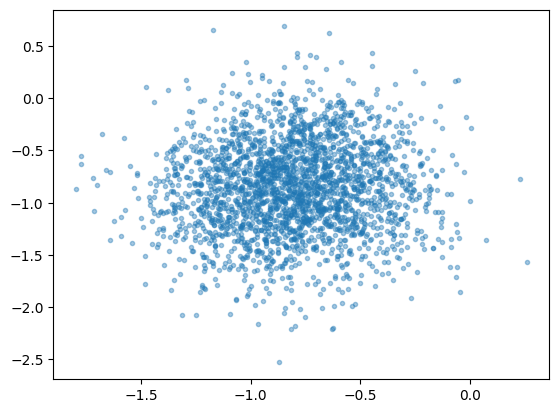

In [7]:
import matplotlib.pyplot as plt

# ode_targ = results_dict["aug_ode"][:, -1,:2]
sde_targ = results_dict["aug"][:, -1,:2]

# plt.plot(ode_targ[:, 0], ode_targ[:, 1], ".", alpha=0.4)
plt.plot(sde_targ[:, 0], sde_targ[:, 1], ".", alpha=0.4)

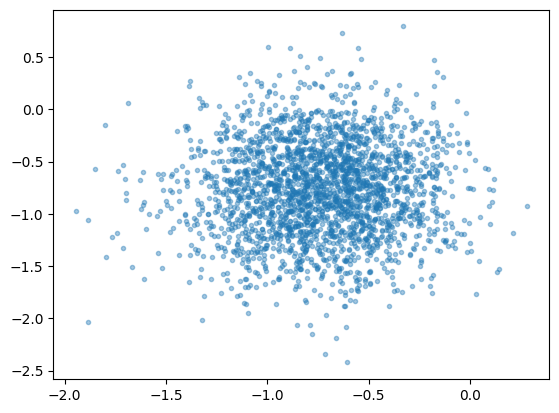

In [8]:
timestep = 90

sde_targ2 = results_dict["aug"][:, timestep,:2]

# plt.plot(ode_targ[:, 0], ode_targ[:, 1], ".", alpha=0.4)
plt.plot(sde_targ2[:, 0], sde_targ2[:, 1], ".", alpha=0.4)

In [9]:
jnp.array(results_dict["is_eval"]).mean()

DeviceArray(110.362976, dtype=float32)

In [10]:
results_dict["is_eval"]

[111.24887084960938,
 111.67249298095703,
 111.4658432006836,
 108.12288665771484,
 111.5942611694336,
 108.801025390625,
 110.53926086425781,
 110.95610046386719,
 108.65692138671875,
 108.48158264160156,
 110.67998504638672,
 111.15666961669922,
 108.50626373291016,
 109.94668579101562,
 110.1197738647461,
 111.89619445800781,
 110.87496948242188,
 110.58623504638672,
 111.44813537597656,
 110.2320327758789,
 110.19707489013672,
 108.64002990722656,
 111.76603698730469,
 110.97672271728516,
 110.42585754394531,
 110.0964584350586,
 110.42211151123047,
 109.76856994628906,
 110.62873077392578,
 110.9814682006836]

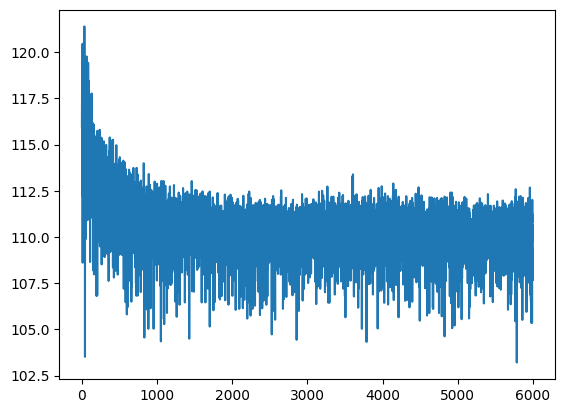

In [11]:
plt.plot(results_dict["is"])

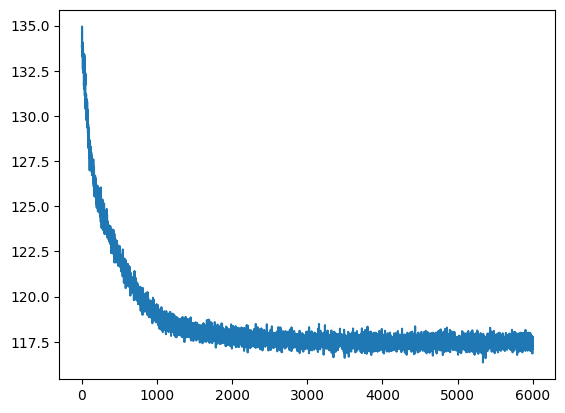

In [12]:
plt.plot(results_dict["elbo"])

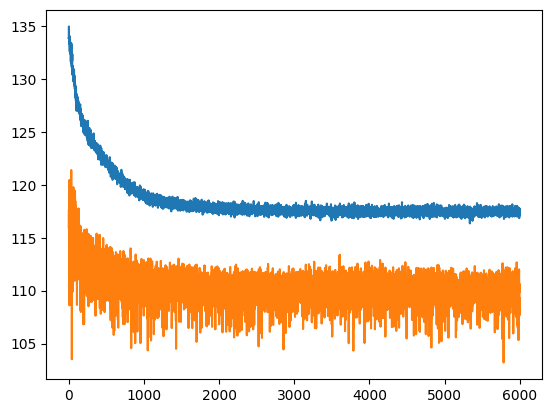

In [13]:
plt.plot(results_dict["elbo"])
plt.plot(results_dict["is"])